# Homework 10

In this homework, you will implement NN using PyTorch and investigate different activation functions, batch sizes, and learning rates. Use [Lecture code](https://github.com/anton-selitskiy/RIT_ML/blob/main/2024_spring/Lectures/ML23.ipynb) as refference.

Use load_planar_dataset function from the previous homework to create the data.

In [83]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn import BCELoss
from torch.optim import Adam
from mlxtend.plotting import plot_decision_regions


In [84]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros(m, dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius. 4 corresponds to the number of petals
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [85]:
x, y = load_planar_dataset()
y = y.reshape(-1,1)
x.shape, y.shape

((400, 2), (400, 1))

##1. (2 pt) Create Dataset object.

In [86]:
class MyData(Dataset):
  def __init__(self, x, y):
    super().__init__()
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, index):
    return torch.tensor(self.x[index], dtype = torch.float), torch.tensor(self.y[index], dtype = torch.float)

data = MyData(x,y)
data[2]

(tensor([ 0.0952, -1.2800]), tensor([0.]))

## 2. (1 pt) Create DataLoader object.

In [87]:
data_loader = DataLoader(data, batch_size=10)

## 3. (3 pt) Construct the model
$$
hidden\_1 \to activation\_1 \to hidden\_2 \to activation\_2  
$$
Use `Sigmoid` function as activation on this step.

In [88]:
class MyModel(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.fc1 = nn.Linear(2, hidden_size)
    self.activ_1 = nn.Sigmoid()
    self.activ_2 = nn.Sigmoid()
    self.fc2 = nn.Linear(hidden_size, 1)

  def forward(self, x_batch):
    o = self.fc1(x_batch)
    o = self.activ_1(o)
    o = self.fc2(o)
    return self.activ_2(o)

In [89]:
model = MyModel(5)

## 4. (3 pt) Write the training loop. Use Binary cross-entropy loss. Also, you can use tqdm function to see the training progress. You can start with learning rate 0.01.

In [90]:
optimizer = Adam(model.parameters(), lr=0.01)
creterion = BCELoss()

hist = []
for epoch in tqdm(range(100)):
  for x_b, y_b in data_loader:
    y_pred = model.forward(x_b)
    loss = creterion(y_pred, y_b)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    hist.append(loss.item())

100%|██████████| 100/100 [00:05<00:00, 17.68it/s]


## 5. (2 pt) Write the prediction class to use it in plot_decision_regions function.

In [91]:
class PredictionClass():
  def __init__(self, model):
    self.model = model

  def predict(self, x):
    with torch.no_grad():
      y_pred = model.forward(torch.tensor(x, dtype=torch.float))
      return np.where(y_pred >= 0.5, 1, 0)

## 6. (2 pt) Plot the loss and decision boundary after the training.

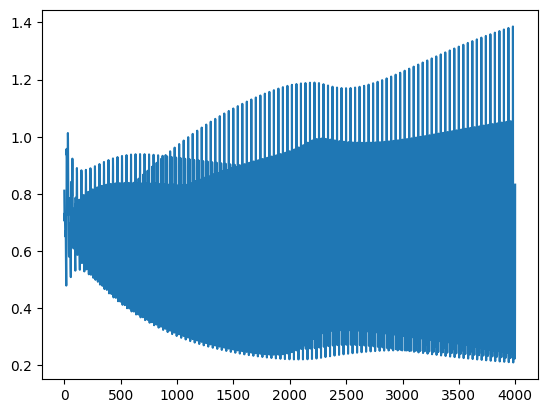

In [92]:
plt.plot(hist)

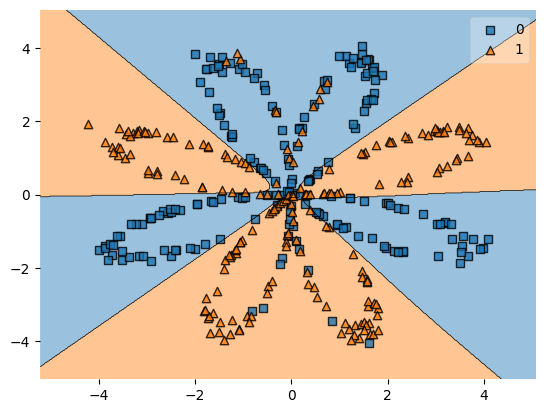

In [93]:
clf = PredictionClass(model)
plot_decision_regions(x,y.reshape(-1,),clf)
plt.show()

## 7. Experiments 1: Try LeakyReLU as `activation_1` with the size of `hidden_1` = 4, 5, and 10. You can reuse the same model without copying it.

In [94]:
hidden_1 = [4, 5, 10]
activation = nn.LeakyReLU()

Activation: LeakyReLU(negative_slope=0.01) ~ Hidden Size: 4


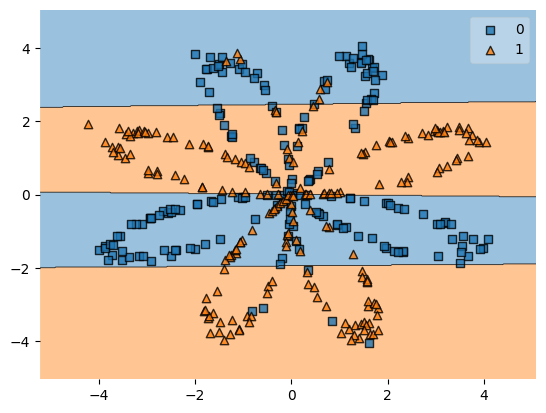



Activation: LeakyReLU(negative_slope=0.01) ~ Hidden Size: 5


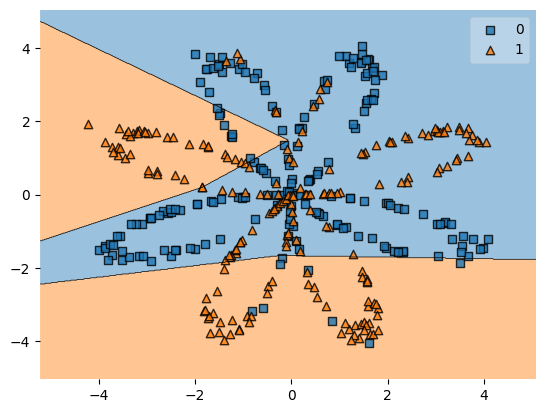



Activation: LeakyReLU(negative_slope=0.01) ~ Hidden Size: 10


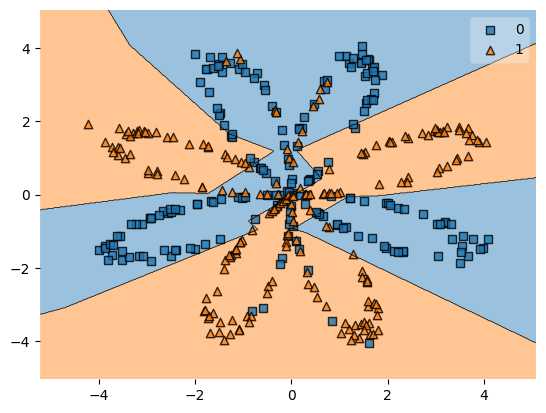

In [95]:
for hidden_size in hidden_1:
  model.fc1 = nn.Linear(2, hidden_size)
  model.fc2 = nn.Linear(hidden_size, 1)
  model.activ_1 = activation

  optimizer = Adam(model.parameters(), lr=0.01)
  creterion = BCELoss()

  for epoch in range(100):
    for x_b, y_b in data_loader:
      y_pred = model.forward(x_b)
      loss = creterion(y_pred, y_b)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

  clf = PredictionClass(model)
  plot_decision_regions(x,y.reshape(-1,),clf)
  print(f"Activation: {model.activ_1} ~ Hidden Size: {hidden_size}")
  plt.show()
  print("\n")

## 8. (3 pt) Comment on the number of the straight lines with respect to the size of the hidden layer.

***It seems that as you increase the hidden layer size, the number of straight seperation lines increases which in return makes the blue and red shades areas smoother and less straight themselves. You can tell by looking at hidden size 4 and seeing how it's basically 3 straight seperation lines with 4 straight shaded areas. Now if you look at hidden size 10, you can see how there are like ~15 seperation lines and the shaded areas are more smoothed out to follow the data.***

## 9. Experiments 2: with the `hidden_1` layer of the size 4 try Sigmoind, ReLU, LeakyReLU, ELU, and SiLU as `activation_1`. Do this for batch sizes 4 and 50.

In [96]:
hidden_1 = 4
batch_sizes = [4, 50]
learning_rates = [0.001, 0.01, 0.1]
activations = [nn.Sigmoid(), nn.ReLU(), nn.LeakyReLU(), nn.ELU(), nn.SiLU()]

Activation: Sigmoid() ~ Batch Size: 4 ~ Learning Rate: 0.001


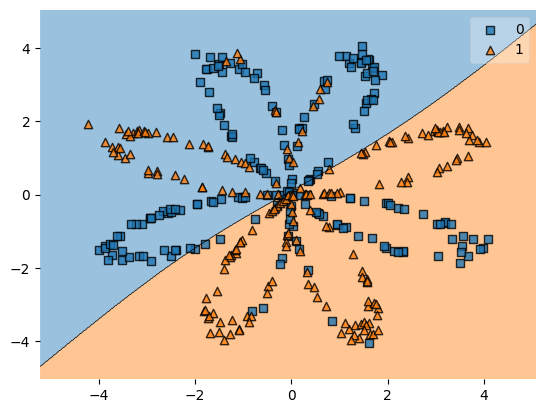



Activation: Sigmoid() ~ Batch Size: 4 ~ Learning Rate: 0.01


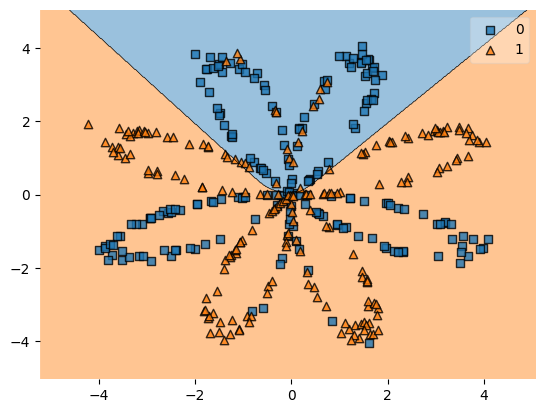



Activation: Sigmoid() ~ Batch Size: 4 ~ Learning Rate: 0.1


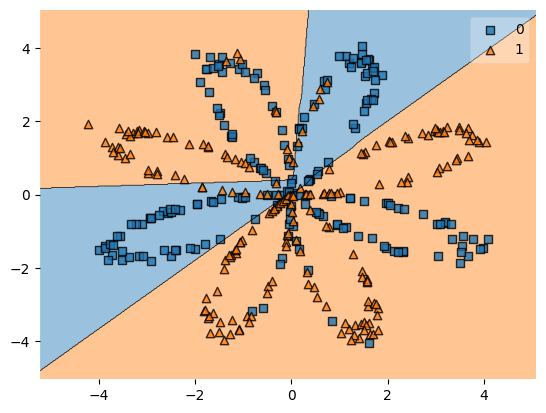



Activation: Sigmoid() ~ Batch Size: 50 ~ Learning Rate: 0.001


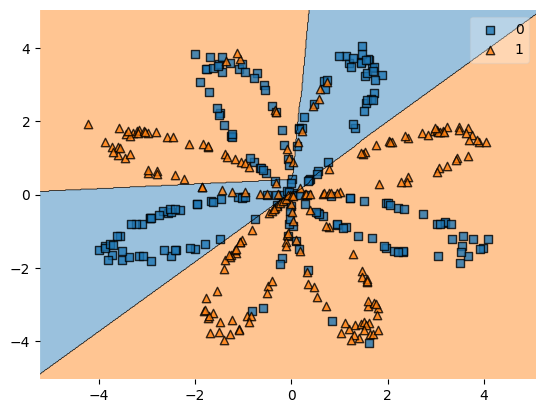



Activation: Sigmoid() ~ Batch Size: 50 ~ Learning Rate: 0.01


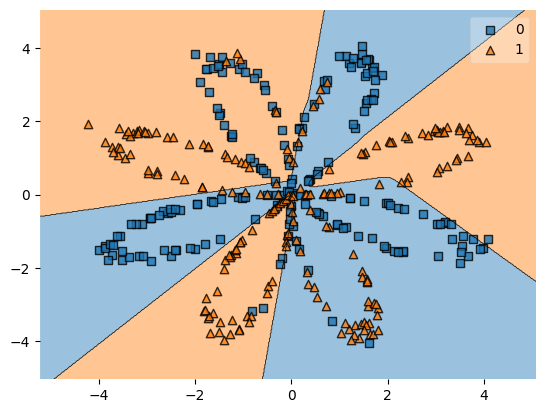



Activation: Sigmoid() ~ Batch Size: 50 ~ Learning Rate: 0.1


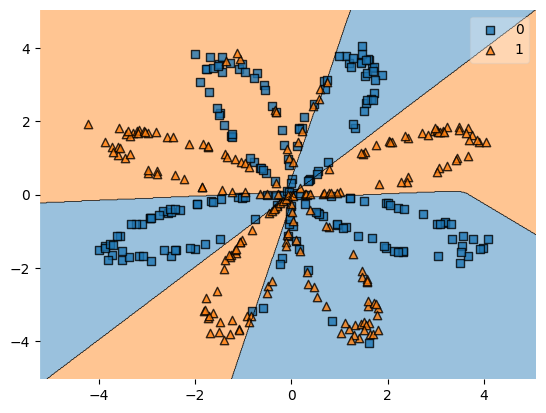



Activation: ReLU() ~ Batch Size: 4 ~ Learning Rate: 0.001


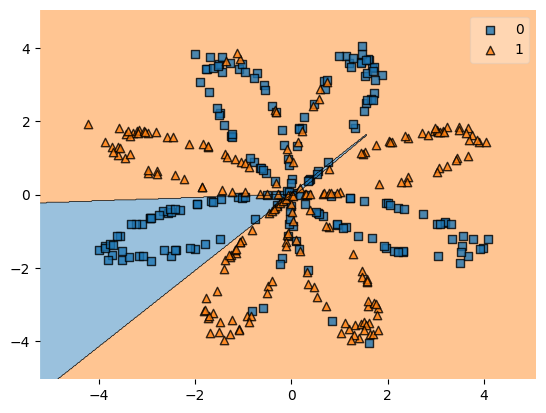



Activation: ReLU() ~ Batch Size: 4 ~ Learning Rate: 0.01


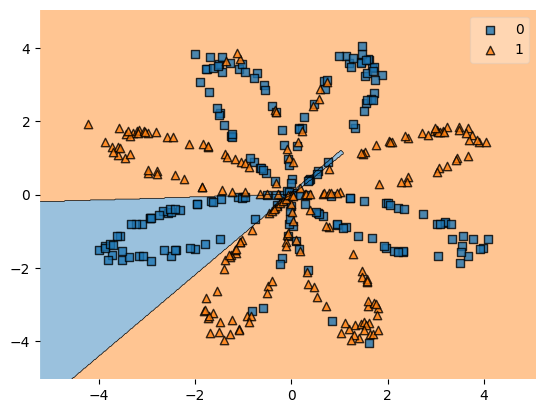



Activation: ReLU() ~ Batch Size: 4 ~ Learning Rate: 0.1


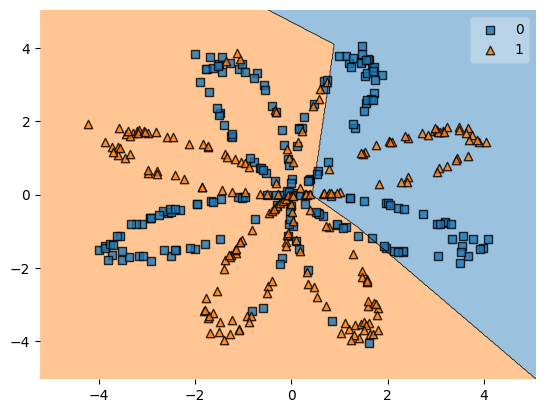



Activation: ReLU() ~ Batch Size: 50 ~ Learning Rate: 0.001


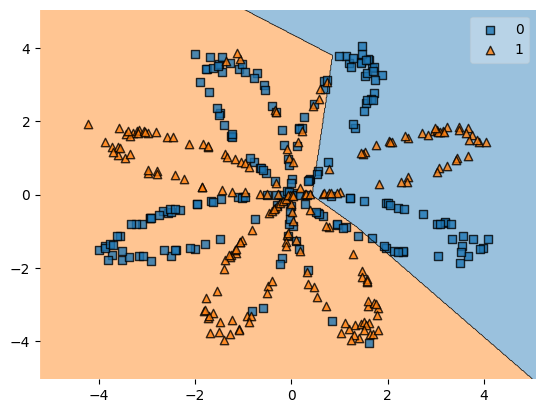



Activation: ReLU() ~ Batch Size: 50 ~ Learning Rate: 0.01


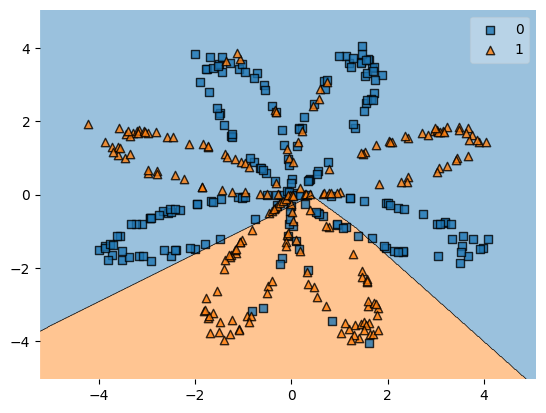



Activation: ReLU() ~ Batch Size: 50 ~ Learning Rate: 0.1


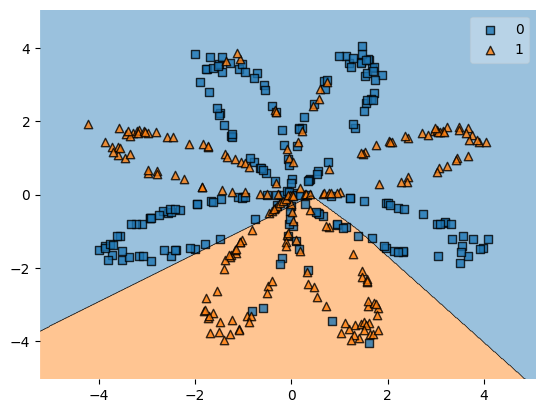



Activation: LeakyReLU(negative_slope=0.01) ~ Batch Size: 4 ~ Learning Rate: 0.001


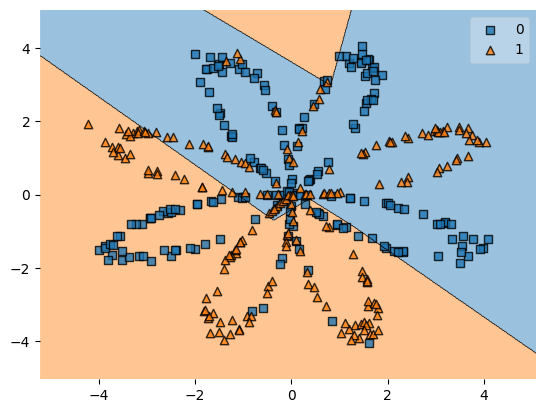



Activation: LeakyReLU(negative_slope=0.01) ~ Batch Size: 4 ~ Learning Rate: 0.01


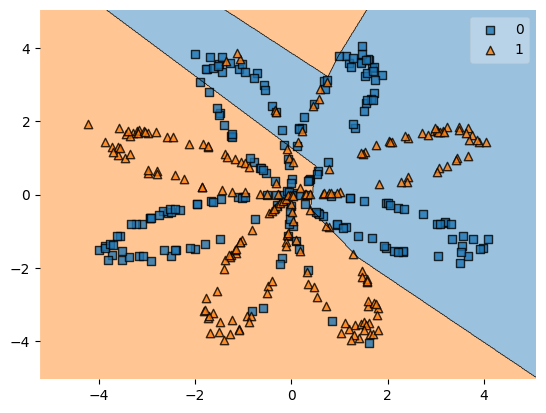



Activation: LeakyReLU(negative_slope=0.01) ~ Batch Size: 4 ~ Learning Rate: 0.1


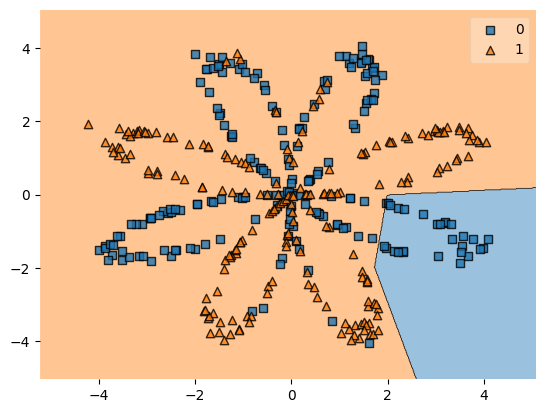



Activation: LeakyReLU(negative_slope=0.01) ~ Batch Size: 50 ~ Learning Rate: 0.001


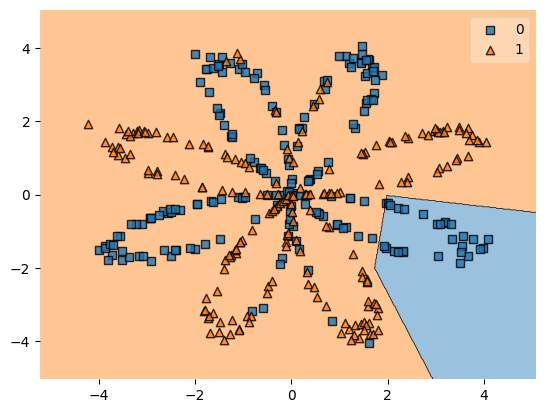



Activation: LeakyReLU(negative_slope=0.01) ~ Batch Size: 50 ~ Learning Rate: 0.01


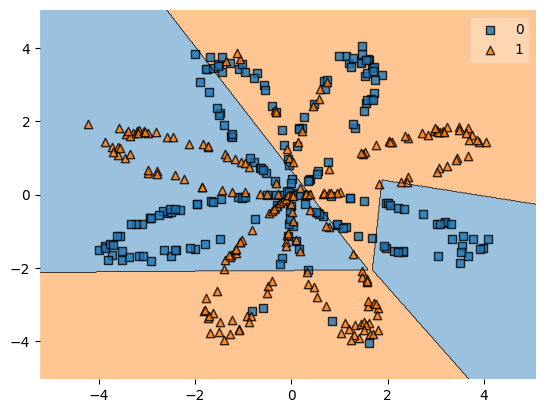



Activation: LeakyReLU(negative_slope=0.01) ~ Batch Size: 50 ~ Learning Rate: 0.1


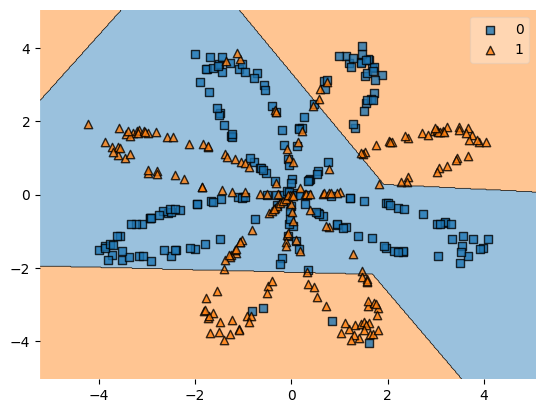



Activation: ELU(alpha=1.0) ~ Batch Size: 4 ~ Learning Rate: 0.001


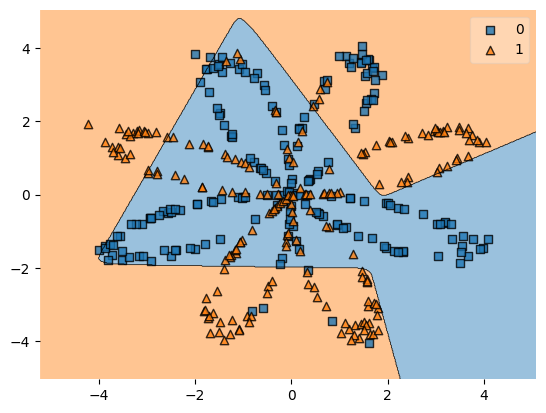



Activation: ELU(alpha=1.0) ~ Batch Size: 4 ~ Learning Rate: 0.01


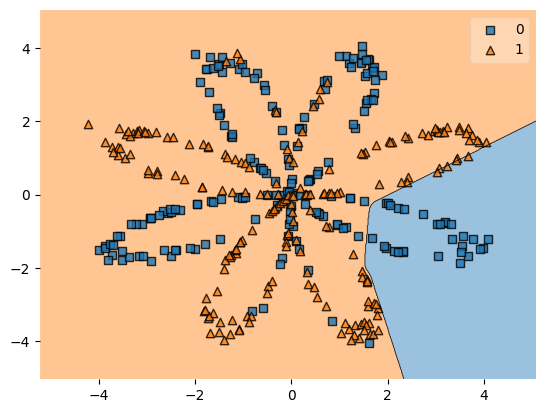



Activation: ELU(alpha=1.0) ~ Batch Size: 4 ~ Learning Rate: 0.1


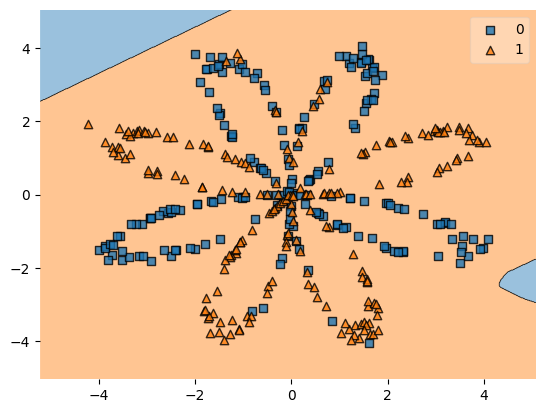



Activation: ELU(alpha=1.0) ~ Batch Size: 50 ~ Learning Rate: 0.001


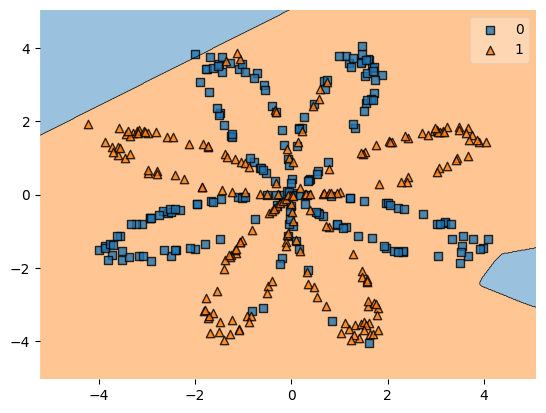



Activation: ELU(alpha=1.0) ~ Batch Size: 50 ~ Learning Rate: 0.01


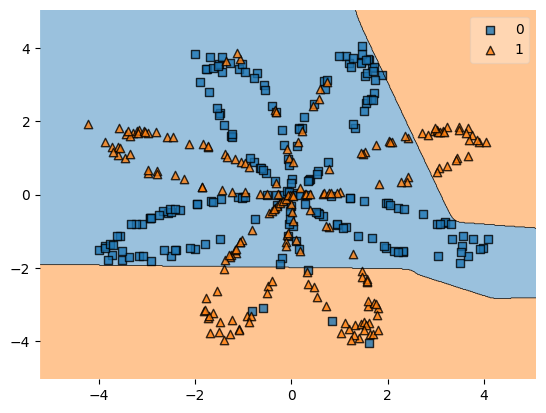



Activation: ELU(alpha=1.0) ~ Batch Size: 50 ~ Learning Rate: 0.1


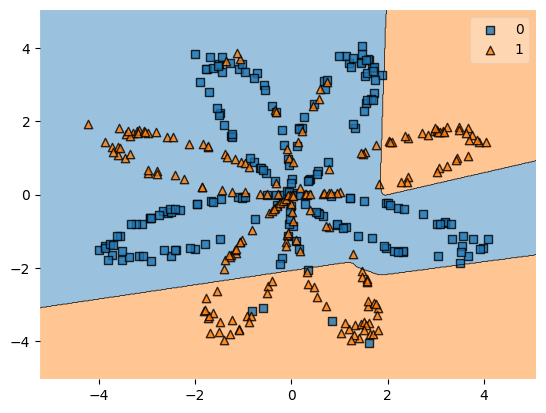



Activation: SiLU() ~ Batch Size: 4 ~ Learning Rate: 0.001


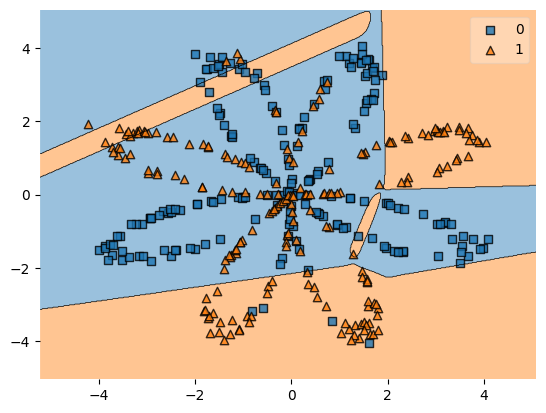



Activation: SiLU() ~ Batch Size: 4 ~ Learning Rate: 0.01


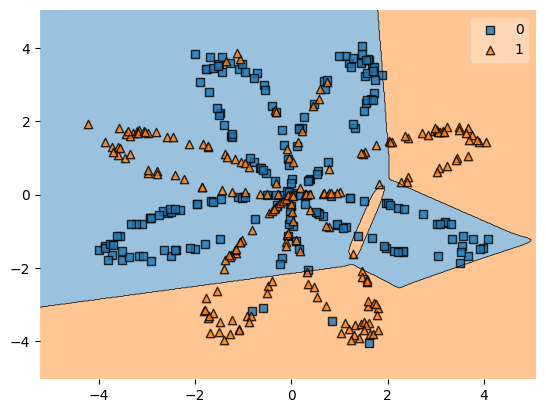



Activation: SiLU() ~ Batch Size: 4 ~ Learning Rate: 0.1


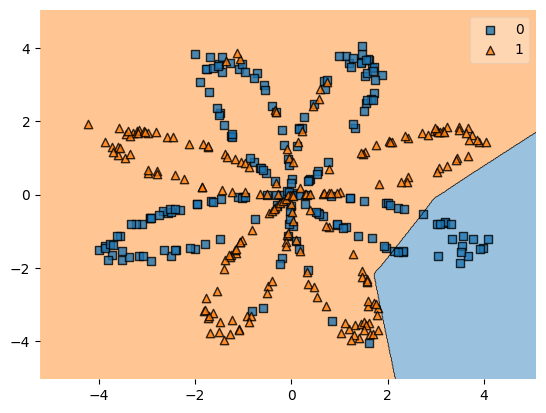



Activation: SiLU() ~ Batch Size: 50 ~ Learning Rate: 0.001


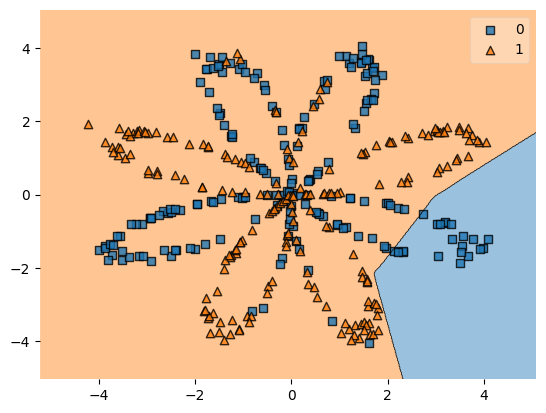



Activation: SiLU() ~ Batch Size: 50 ~ Learning Rate: 0.01


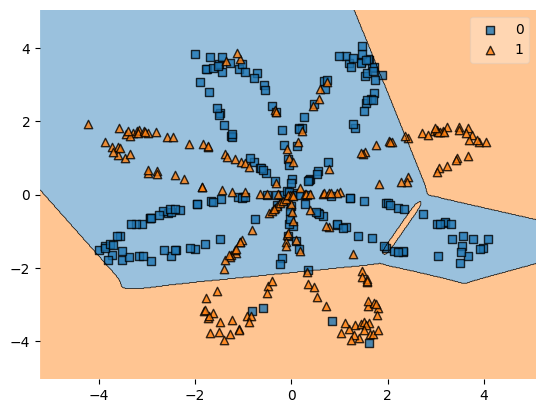



Activation: SiLU() ~ Batch Size: 50 ~ Learning Rate: 0.1


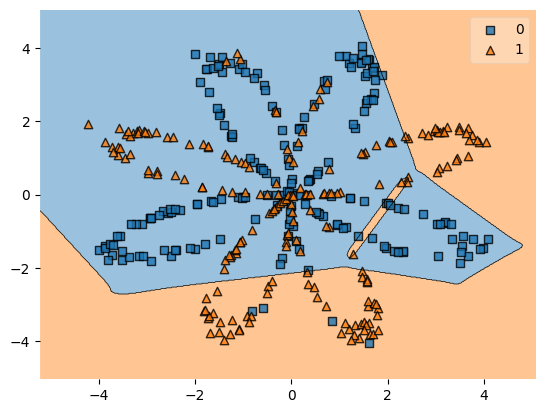

In [97]:
model.fc1 = nn.Linear(2, hidden_1)
model.fc2 = nn.Linear(hidden_1, 1)

for activation in activations:
  for batch_size in batch_sizes:
    for learning_rate in learning_rates:
      data_loader = DataLoader(data, batch_size=batch_size)

      model.activ_1 = activation

      optimizer = Adam(model.parameters(), lr=learning_rate)
      creterion = BCELoss()

      for epoch in range(100):
        for x_b, y_b in data_loader:
          y_pred = model.forward(x_b)
          loss = creterion(y_pred, y_b)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

      clf = PredictionClass(model)
      plot_decision_regions(x,y.reshape(-1,),clf)
      print(f"Activation: {model.activ_1} ~ Batch Size: {batch_size} ~ Learning Rate: {learning_rate}")
      plt.show()
      print("\n")

## 10. (4 pt) Comment on the shape of the decision boundaries with respect to the activation function and the batch size. Did you adjust the learning rate? Did you try to start with small learning rate like 0.001 instead of 0.01 and if so, which worked better?

***Sigmoid: Tries it's best to seperate the data points but with batch size 4 it only seems to capture a few petals (until we turn up the learning rate to 0.1) whilst batch size 50 tries to cater towards the shape of the petal more.***

***ReLU: More reserved with batch size 4 on basically all learning rates, however once we turn up batch size to 50 it tries to capture more of the petals. In either cases it does "broad sweeps" of classifications, nothing intricate.***

***LeakyReLU: LeakyReLU makes more broader sweeps of classification with batch size 50 whilst it's more intricate with a batch_size 4.***

***ELU: The shape is a little weird, it tries to capture most of the data in the shaded area whilst leaving a few points outside the designed shaded region to avoid capturing the opposing points. Increasing the batch size made the shaded region larger.***

***SiLU: Does he exact same thing as ELU but it includes some interwoven opposing shaded regions to remove those points. Copies ELU batch size behavior.***


***In regards to learning rate, it seems like 0.1 lr actually worked the best with batch size 50 and 0.001 lr worked the best with batch size 4.***